In [1]:
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import os

## 0. Introduction

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html#:~:text=CIFAR-10%20python%20version) is a widely used benchmark in the field of computer vision and machine learning. It consists of 60,000 color images, each sized 32x32 pixels, categorized into 10 distinct classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Each class contains 6,000 images, with 50,000 images designated for training and 10,000 for testing.

Due to its manageable size and diversity, CIFAR-10 is ideal for experimenting with and evaluating image classification algorithms, especially convolutional neural networks (CNNs). In this notebook, we leverage the CIFAR-10 dataset to build, train, and evaluate CNN models for image classification. The workflow includes data preprocessing, model architecture design, training, and performance evaluation, providing a practical demonstration of how deep learning techniques can be applied to solve real-world image recognition tasks.

## 1. Initial Dataset Loading and Exploration

### 1.1. Initial dataset loading

In [2]:
# Tensor transformation for initial dataset loading
initial_transform = transforms.ToTensor()

# Load CIFAR-10 dataset
initial_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=initial_transform)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### 1.2. Sample images preview


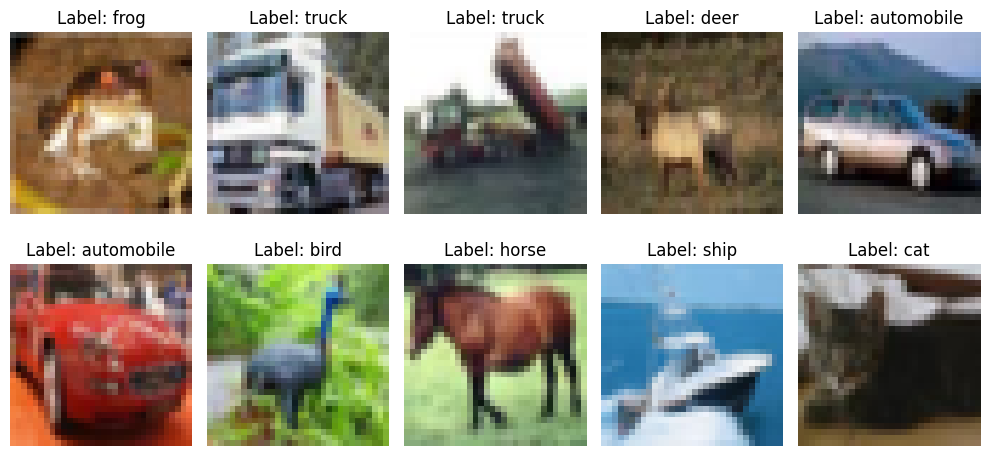

In [3]:
# Get first 10 images and labels
images = [initial_train_dataset[i][0] for i in range(10)]
labels = [initial_train_dataset[i][1] for i in range(10)]

# Plot using matplotlib
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    img = images[i].permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C] for plotting
    ax.imshow(img)
    ax.set_title(f'Label: {class_names[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## 2. Preprocessing

### 2.1. Finding mean and standard deviation for the training dataset three image channels (RGB)

Despite that channel-wise mean and std of CIFAR-10 dataset are available online, I choose to recalculate them myself here for the sake of practice and better understanding.

In [4]:
# Initialize DataLoader to load initial train dataset
loader_for_stats = DataLoader(initial_train_dataset, batch_size=50000, shuffle=False)

# Iterate through the DataLoader
data_for_stats = next(iter(loader_for_stats))[0]  # shape: [50000, 3, 32, 32]

# Calculate and print mean and std for each channel
mean = data_for_stats.mean(dim=[0, 2, 3])
std = data_for_stats.std(dim=[0, 2, 3])

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


### 2.2. Building transformation pipelines for both train and test datasets

In [5]:
# Train dataset transformations
## Train dataset transformations aims to augment the data with random transformations to improve model generalization.
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Horizontal flip
    transforms.RandomRotation(15), # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Color jitter with brightness, contrast and saturation adjustments
    transforms.RandomCrop(32, padding=4), # Random crop with padding to simulate zooming
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize(mean=mean, std=std), # Normalize the images with calculated channel-wise mean and std
])

## Test data transformations aims to standardize the data without augmentation to evaluate model performance accurately.
transform_test = transforms.Compose([
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize(mean=mean, std=std), # Normalize the images with calculated channel-wise mean and std
])

### 2.3. Loading final train and test datasets with the built transformation pipelines

In [6]:
# Load final datasets with built transformations
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### 2.4. Sample train images with transformations preview

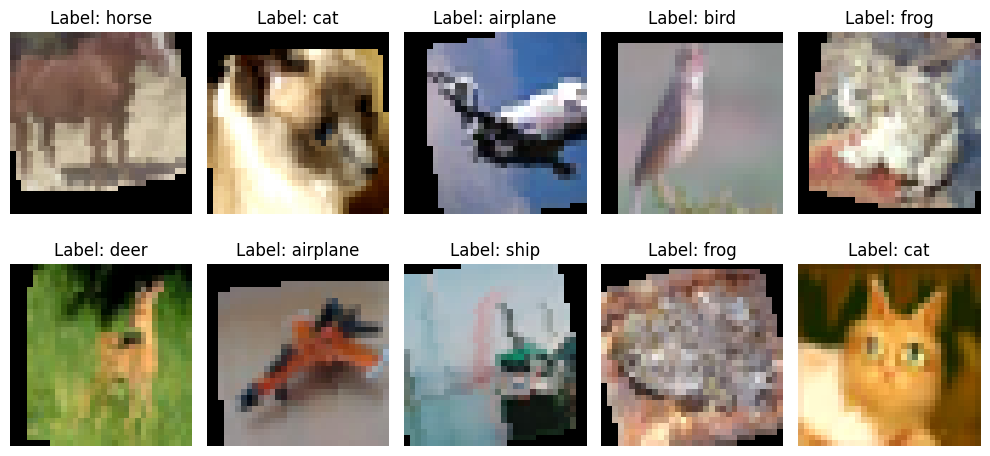

In [7]:
# Iterate through the train DataLoader to get a batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot using matplotlib
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    img = images[i] * std.view(3, 1, 1) + mean.view(3, 1, 1) # Unnormalize images for display
    img = img.permute(1, 2, 0) # Convert back from [C, H, W] to [H, W, C] for plotting
    ax.imshow(img)
    ax.set_title(f'Label: {class_names[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Model Architecture and Training Loop

Also for the sake of practice and research, I built two convolutional neural networks (CNNs), with two slightly different architectures to see the impact of the change.

**SimpleCNN:** Clean, interpretable and unexpensive base CNN model.

**ModifiedSimpleCNN:** Similar to *SimpleCNN* but with added lightweight enhancements; batch normalization and dropout.

At the end of this section, I compared between the two architectures, and moved on to evaluation with the best performing model.

### 3.1. *SimpleCNN*

In [8]:
# Define the SimpleCNN architecture
class SimpleCNN(nn.Module):
    def __init__ (self):
        super(SimpleCNN, self).__init__()

        # Two convolutional layers to learn spatial features from the input images and detect patterns, like edges, textures, and shapes.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Max pooling layer to reduce the spatial dimensions of the feature maps, which helps in reducing the computational load and controlling overfitting.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Two fully connected layers to learn high-level representations and perform the final classification based on the features extracted by the convolutional layers.
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fcs2 = nn.Linear(128, 10)

    # Define the forward pass
    def forward(self, x):
        # Apply convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output 3D feature map from the convolutional layers into a 1D vector so it can go into fully connected layers
        x = x.view(-1, 64 * 8 * 8)

        # Apply fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fcs2(x)

        return x

In [9]:
# Initialize model
model = SimpleCNN()

# Set device to GPU if available, and CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Define number of epochs 
num_epochs = 15

# Define lists to store training accuracy and loss to use for validation plotting later if the model is chosen for validation
train_accs = []
train_losses = []

# Training loop for num_epochs full passes over the dataset
## Each epoch is a fresh opportunity for the model to learn from its mistakes.
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0 # To accumulate loss over batches
    correct = 0 # To count correct predictions
    total = 0 # To count total samples

    # Loop over batches of data
    for images, labels in train_loader:
        # Move images and labels to the device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Clear old gradients from the previous batches
        ## Prevents accumulation of gradients across batches
        optimizer.zero_grad()

        # Forward pass: Feeding the batch to the model
        outputs = model(images)
        # Computing loss by comparing model outputs to true labels
        loss = criterion(outputs, labels)
        # Backpropagation to compute gradients of the loss with respect to model parameters
        ## These gradients tell the model how to adjust its weights to reduce the loss
        loss.backward()
        # Applying weight update to the model's parameters using the optimizer
        optimizer.step()

        # Add the current batch loss to running loss
        running_loss += loss.item()
        # Get the predicted class by finding the index of the max log-probability
        _, predicted = outputs.max(1) # The underscore (_) is used to ignore the first output (max values), we only need the indices

        # Add the number of samples in the current batch to total
        total += labels.size(0)
        # Add the number of correct predictions in the current batch to correct
        correct += predicted.eq(labels).sum().item()

    # Calculate the training accuracy as a percentage and append to the list
    train_acc = 100. * correct / total
    train_accs.append(train_acc)

    # Calculate the average loss over all batches in the epoch and append to the list
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.2f}%')


Epoch [1/15], Loss: 1.5842, Training Accuracy: 42.27%
Epoch [2/15], Loss: 1.2850, Training Accuracy: 53.72%
Epoch [3/15], Loss: 1.1682, Training Accuracy: 58.14%
Epoch [4/15], Loss: 1.0921, Training Accuracy: 61.09%
Epoch [5/15], Loss: 1.0396, Training Accuracy: 63.07%
Epoch [6/15], Loss: 0.9961, Training Accuracy: 64.66%
Epoch [7/15], Loss: 0.9707, Training Accuracy: 65.83%
Epoch [8/15], Loss: 0.9406, Training Accuracy: 66.68%
Epoch [9/15], Loss: 0.9186, Training Accuracy: 67.51%
Epoch [10/15], Loss: 0.8952, Training Accuracy: 68.30%
Epoch [11/15], Loss: 0.8797, Training Accuracy: 69.15%
Epoch [12/15], Loss: 0.8674, Training Accuracy: 69.35%
Epoch [13/15], Loss: 0.8573, Training Accuracy: 69.45%
Epoch [14/15], Loss: 0.8438, Training Accuracy: 70.39%
Epoch [15/15], Loss: 0.8312, Training Accuracy: 70.53%


We note that *SimpleCNN* can reach accuracy of more than 70% over 15 epochs.

### 3.2. *ModifiedSimpleCNN*

The only two differences in this modified version of the model are batch normalization and dropout, which are highlighted by the comments below.

In [11]:
class ModifiedSimpleCNN(nn.Module):
    def __init__ (self):
        super(ModifiedSimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Apply batch normalization after the first convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Apply batch normalization after the second convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        # Apply dropout with a probability of 0.5 after the first fully connected layer
        ## Dropout randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting
        self.dropout = nn.Dropout(0.5) 
        self.fcs2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Forward pass through first conv layer, batch norm, ReLU, and pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # Forward pass through second conv layer, batch norm, ReLU, and pooling

        x = x.view(-1, 64 * 8 * 8)

        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout during forward pass
        x = self.fcs2(x)

        return x

In [12]:
# Initialize modified model with the same device, loss function, and optimizer
modified_model = ModifiedSimpleCNN()
modified_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modified_model.parameters(), lr=0.001)

In [13]:
# Apply training loop to modified model as above
num_epochs = 10 # Number of epochs was kept to 10 after noticing the underperformance of the modified model anyways

modified_train_accs = []
modified_model_losses = []

for epoch in range(num_epochs):
    modified_model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = modified_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    modified_train_accs.append(train_acc)
    avg_loss = running_loss / len(train_loader)
    modified_model_losses.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.2f}%')


Epoch [1/10], Loss: 1.8515, Training Accuracy: 30.10%
Epoch [2/10], Loss: 1.6895, Training Accuracy: 35.95%
Epoch [3/10], Loss: 1.6118, Training Accuracy: 39.39%
Epoch [4/10], Loss: 1.5585, Training Accuracy: 41.43%
Epoch [5/10], Loss: 1.5192, Training Accuracy: 42.99%
Epoch [6/10], Loss: 1.4984, Training Accuracy: 43.79%
Epoch [7/10], Loss: 1.4693, Training Accuracy: 45.08%
Epoch [8/10], Loss: 1.4509, Training Accuracy: 45.48%
Epoch [9/10], Loss: 1.4283, Training Accuracy: 47.06%
Epoch [10/10], Loss: 1.4194, Training Accuracy: 47.01%


We note that the modified model is significantly underperforming compared to the based model.

**Conclusion:** Therefore, I moved on with the base model to evaluate and test.

## 4. Model Evaluation

In the evaluation, I evaluated the model against the test dataset, generating test accuracy metric and evaluation plots, in addition to testing against few real world images for the sake of curiosity.

### 4.1. Test dataset

In [14]:
# Initialize model for evaluation
model.eval()

correct = 0 # To count correct predictions
total = 0 # To count total samples

# Evaluate the model on the test dataset without computing gradients
with torch.no_grad(): # No need to compute gradients during evaluation
    for images, labels in test_loader:
        # Move images and labels to the device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        # Apply the model to get outputs
        outputs = model(images)
        # Get the predicted class by finding the index of the max log-probability
        _, predicted = outputs.max(1)
        # Add the number of samples in the current batch to total
        total += labels.size(0)
        # Add the number of correct predictions in the current batch to correct
        correct += predicted.eq(labels).sum().item()
# Calculate the test accuracy as a percentage and print it
test_acc = 100. * correct / total
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 73.13%


#### 4.1.1. Preview sample of misclassified images

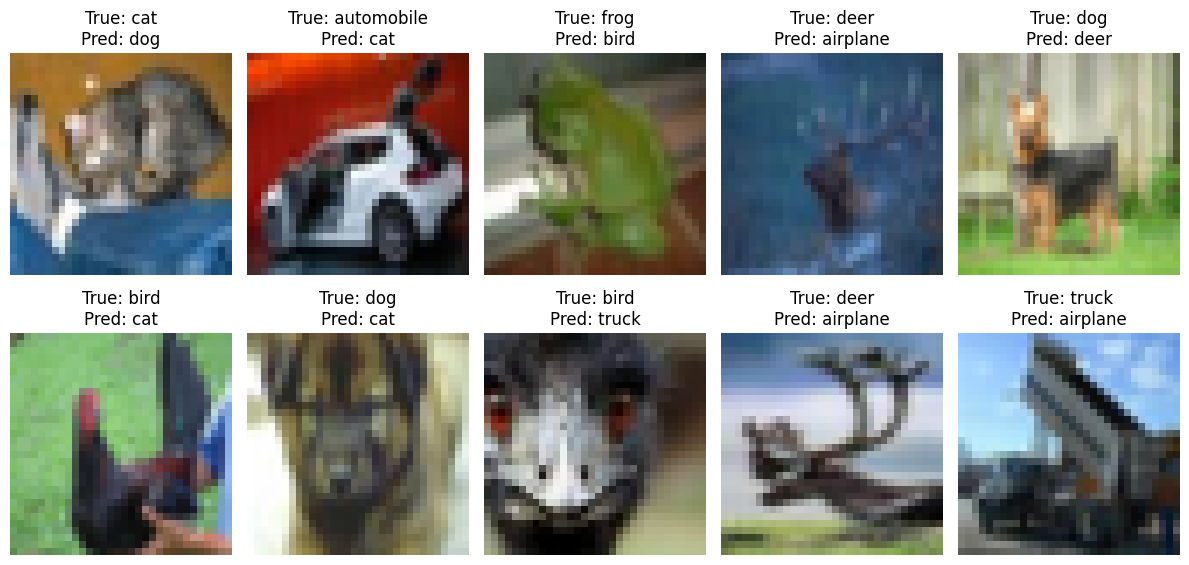

In [15]:
# Initialize list to store misclassified images, their predicted labels, and true labels
misclassified = []

# Initialize model for evaluation
model.eval()
# Evaluate the model on the test dataset without computing gradients as above
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))
            if len(misclassified) >= 10: # Keep collecting misclassified images until we have 10
                break
        if len(misclassified) >= 10: # Keep collecting misclassified images until we have 10
            break

# Plot the first 10 misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    img, pred, true = misclassified[i]
    ax.imshow(img.permute(1, 2, 0) * std + mean) # Unnormalize for display and convert from [C, H, W] to [H, W, C]
    ax.set_title(f'True: {class_names[true]}\nPred: {class_names[pred]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

#### 4.1.2. Visualizing train accuracy and loss over epochs

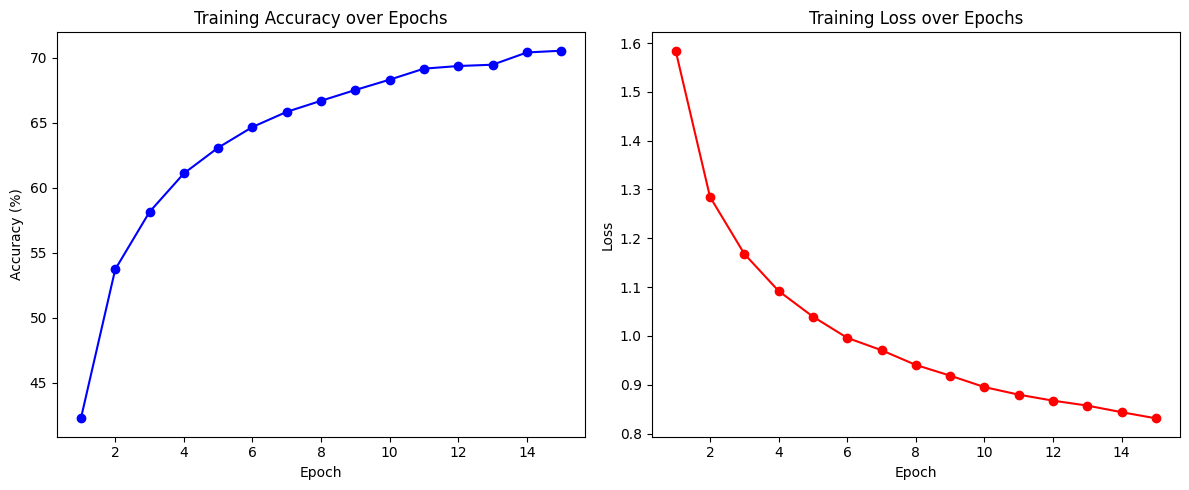

In [16]:
epochs = list(range(1, 16)) # The base model had 15 epochs

train_accs_plot = train_accs # Use training accuracies from the base model
train_losses_plot = train_losses # Use training losses from the base model

plt.figure(figsize=(12, 5))

# Training accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs_plot, marker='o', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# Training loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses_plot, marker='o', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

### 4.2. Real-world examples testing

In [17]:
# Initialize transformation for real-world images
transform_real = transforms.Compose([
    transforms.Resize((32, 32)), # Resize to 32x32 pixels to match CIFAR-10 input size
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize(mean=mean, std=std), # Normalize with calculated mean and std to match training data distribution
])

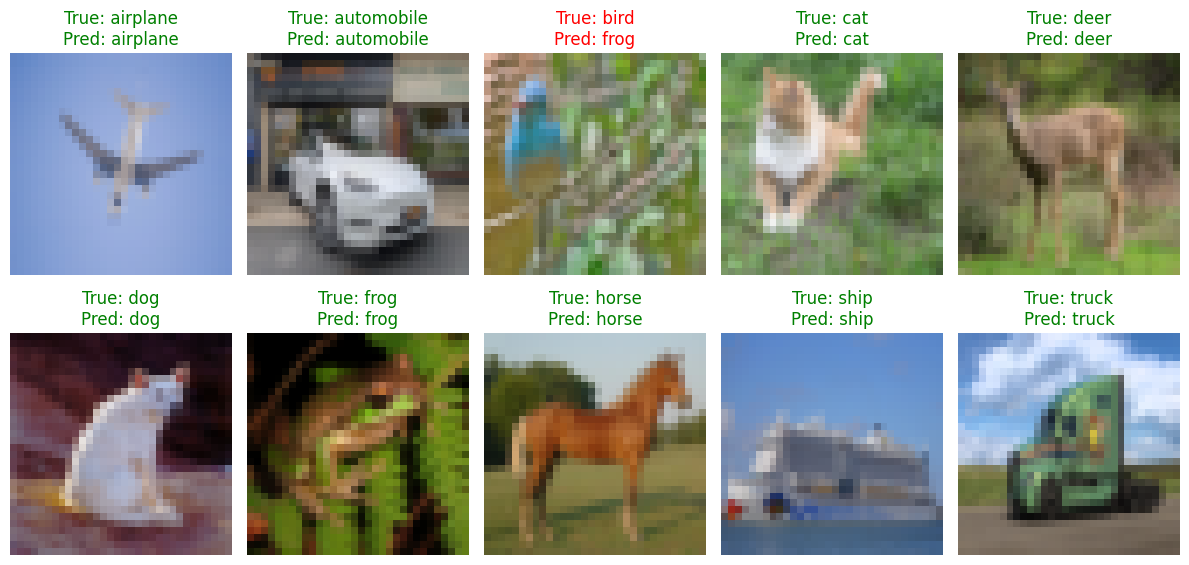

In [18]:
folder_path = 'real_world_images' # Path to the folder containing real-world images

# Initialize model for evaluation
model.eval()

# Initialize 2x5 grid for displaying images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten() # Flatten axes array for easy indexing

# Evaluate the model on real-world images without computing gradients
with torch.no_grad():
    for i, filename in enumerate(os.listdir(folder_path)):
        if i >= 10:
            break
        path = os.path.join(folder_path, filename) # Get full path to real-world images from subfolder
        image = Image.open(path).convert('RGB') # Open image and convert to RGB
        input_tensor = transform_real(image).unsqueeze(0).to(device) # Apply transformations and add batch dimension

        # Apply the model to get outputs and predictions
        output = model(input_tensor)
        _, predicted = output.max(1)

        # Get true label from filename and compare with predicted label
        true_label = filename.split('.')[0].rstrip('0123456789')
        pred_label = class_names[predicted.item()]
        is_correct = (true_label == pred_label)

        # Display the image with true and predicted labels
        img_display = input_tensor.squeeze(0).cpu() * std.view(3, 1 ,1) + mean.view(3, 1 ,1)
        axes[i].imshow(img_display.permute(1, 2, 0))
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color='green' if is_correct else 'red')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## 5. Conclusion

In this notebook, we explored the process of building, training, and evaluating convolutional neural networks (CNNs) for image classification using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html#:~:text=CIFAR-10%20python%20version) dataset. We covered data preprocessing, model architecture design, training loops, and performance evaluation, including visualization of results and testing on real-world images.

Through experimentation with both a simple CNN and a modified version with batch normalization and dropout, we observed the impact of architectural changes on model performance. The base model achieved solid accuracy, demonstrating the effectiveness of standard CNNs for image classification tasks on CIFAR-10.

This workflow provides a practical foundation for further experimentation, such as tuning hyperparameters, exploring deeper architectures, or applying transfer learning. The skills and techniques demonstrated here are broadly applicable to a wide range of computer vision problems.

--

Reference

Krizhevsky, A. and Hinton, G. (2007) Learning Multiple Layers of Features from Tiny Images. Available at: https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf (Accessed: 27 September 2025).